In [1]:
pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crlibm: filename=crlibm-1.0.3-cp37-cp37m-linux_x86_64.whl size=171016 sha256=f4e03e7062e0b8f17c74342243523c57cf40006d7962ba2f1b9937bb7f9dc3f7
  Stored in directory: /root/.cache/pip/wheels/cc/15/34/8ef948696d9025731624e5a5dbfd143f70a1ef24fb69b0d1a6
Successfully built crlibm
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffprivlib.tools.utils as dp
import warnings
from diffprivlib.utils import PrivacyLeakWarning, DiffprivlibCompatibilityWarning
import random
import csv
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression, GaussianNB
from diffprivlib.mechanisms import ExponentialCategorical
from sklearn.naive_bayes import GaussianNB as GNB_skl
from sklearn.linear_model import LogisticRegression as LR_skl
from sklearn.metrics import accuracy_score
from sklearn import datasets
import seaborn as sns

# Suppress the PrivacyLeakWarning
warnings.simplefilter("ignore", PrivacyLeakWarning)
warnings.simplefilter("ignore", DiffprivlibCompatibilityWarning)

print("Libraries imported")

Libraries imported


## 1. Census data for privatization

### 1.1 Import data to be privatized

In [3]:
# Load the data
df = pd.read_csv("/kaggle/input/pii-data/adult_with_pii.csv")
df.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 1.2 Data pre-processing

<AxesSubplot:>

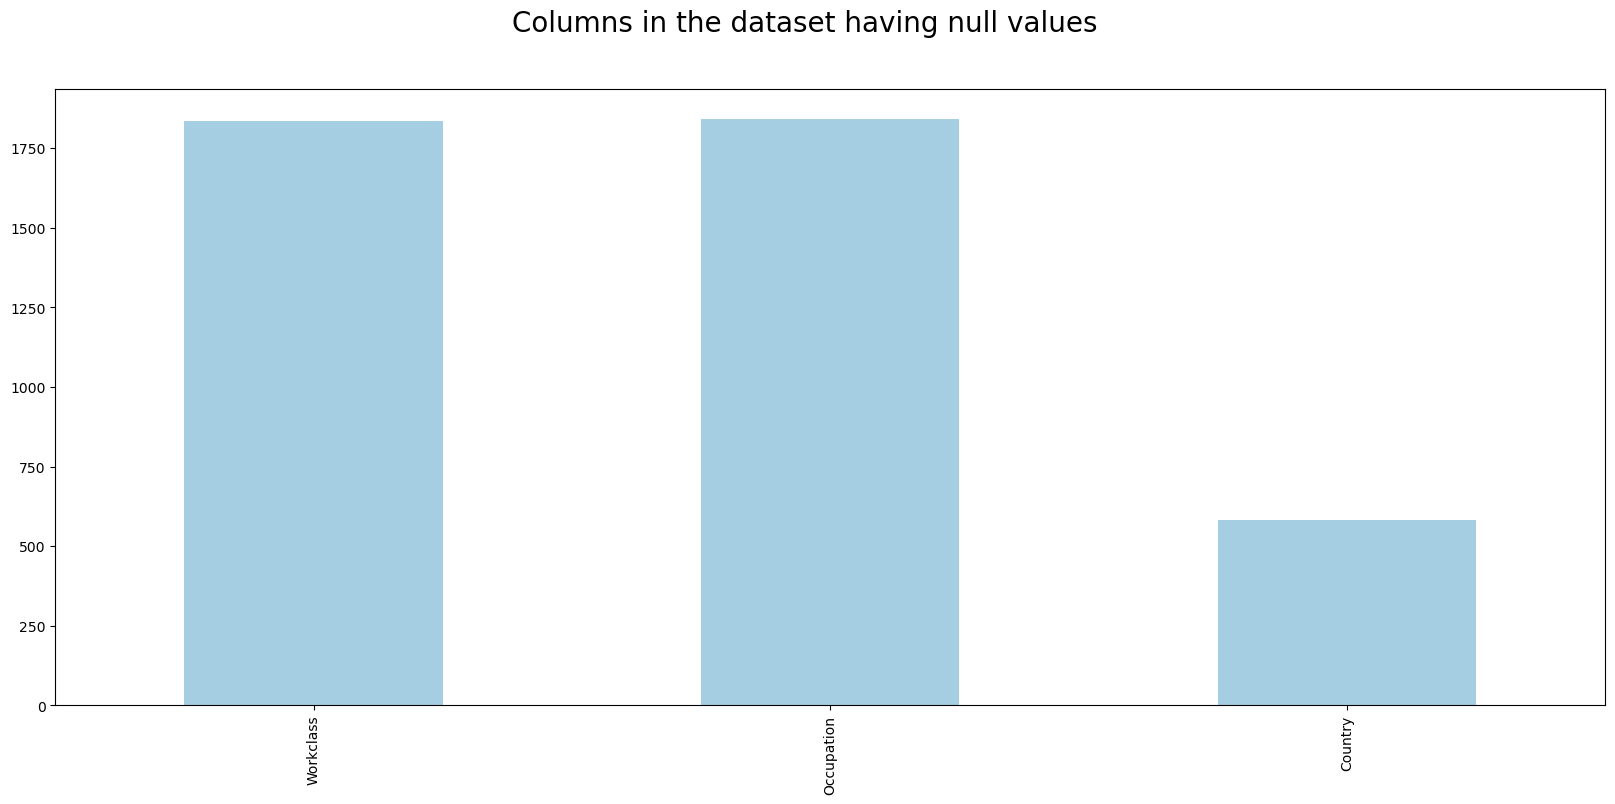

In [4]:
fig = plt.figure(figsize=(20, 8))
fig.suptitle("Columns in the dataset having null values", fontsize=20)
df.isna().sum()[df.isna().sum()>0].plot(kind='bar', colormap='Paired')

In [5]:
# Drop all rows that contain NaN values since these are very few
df = df.dropna()

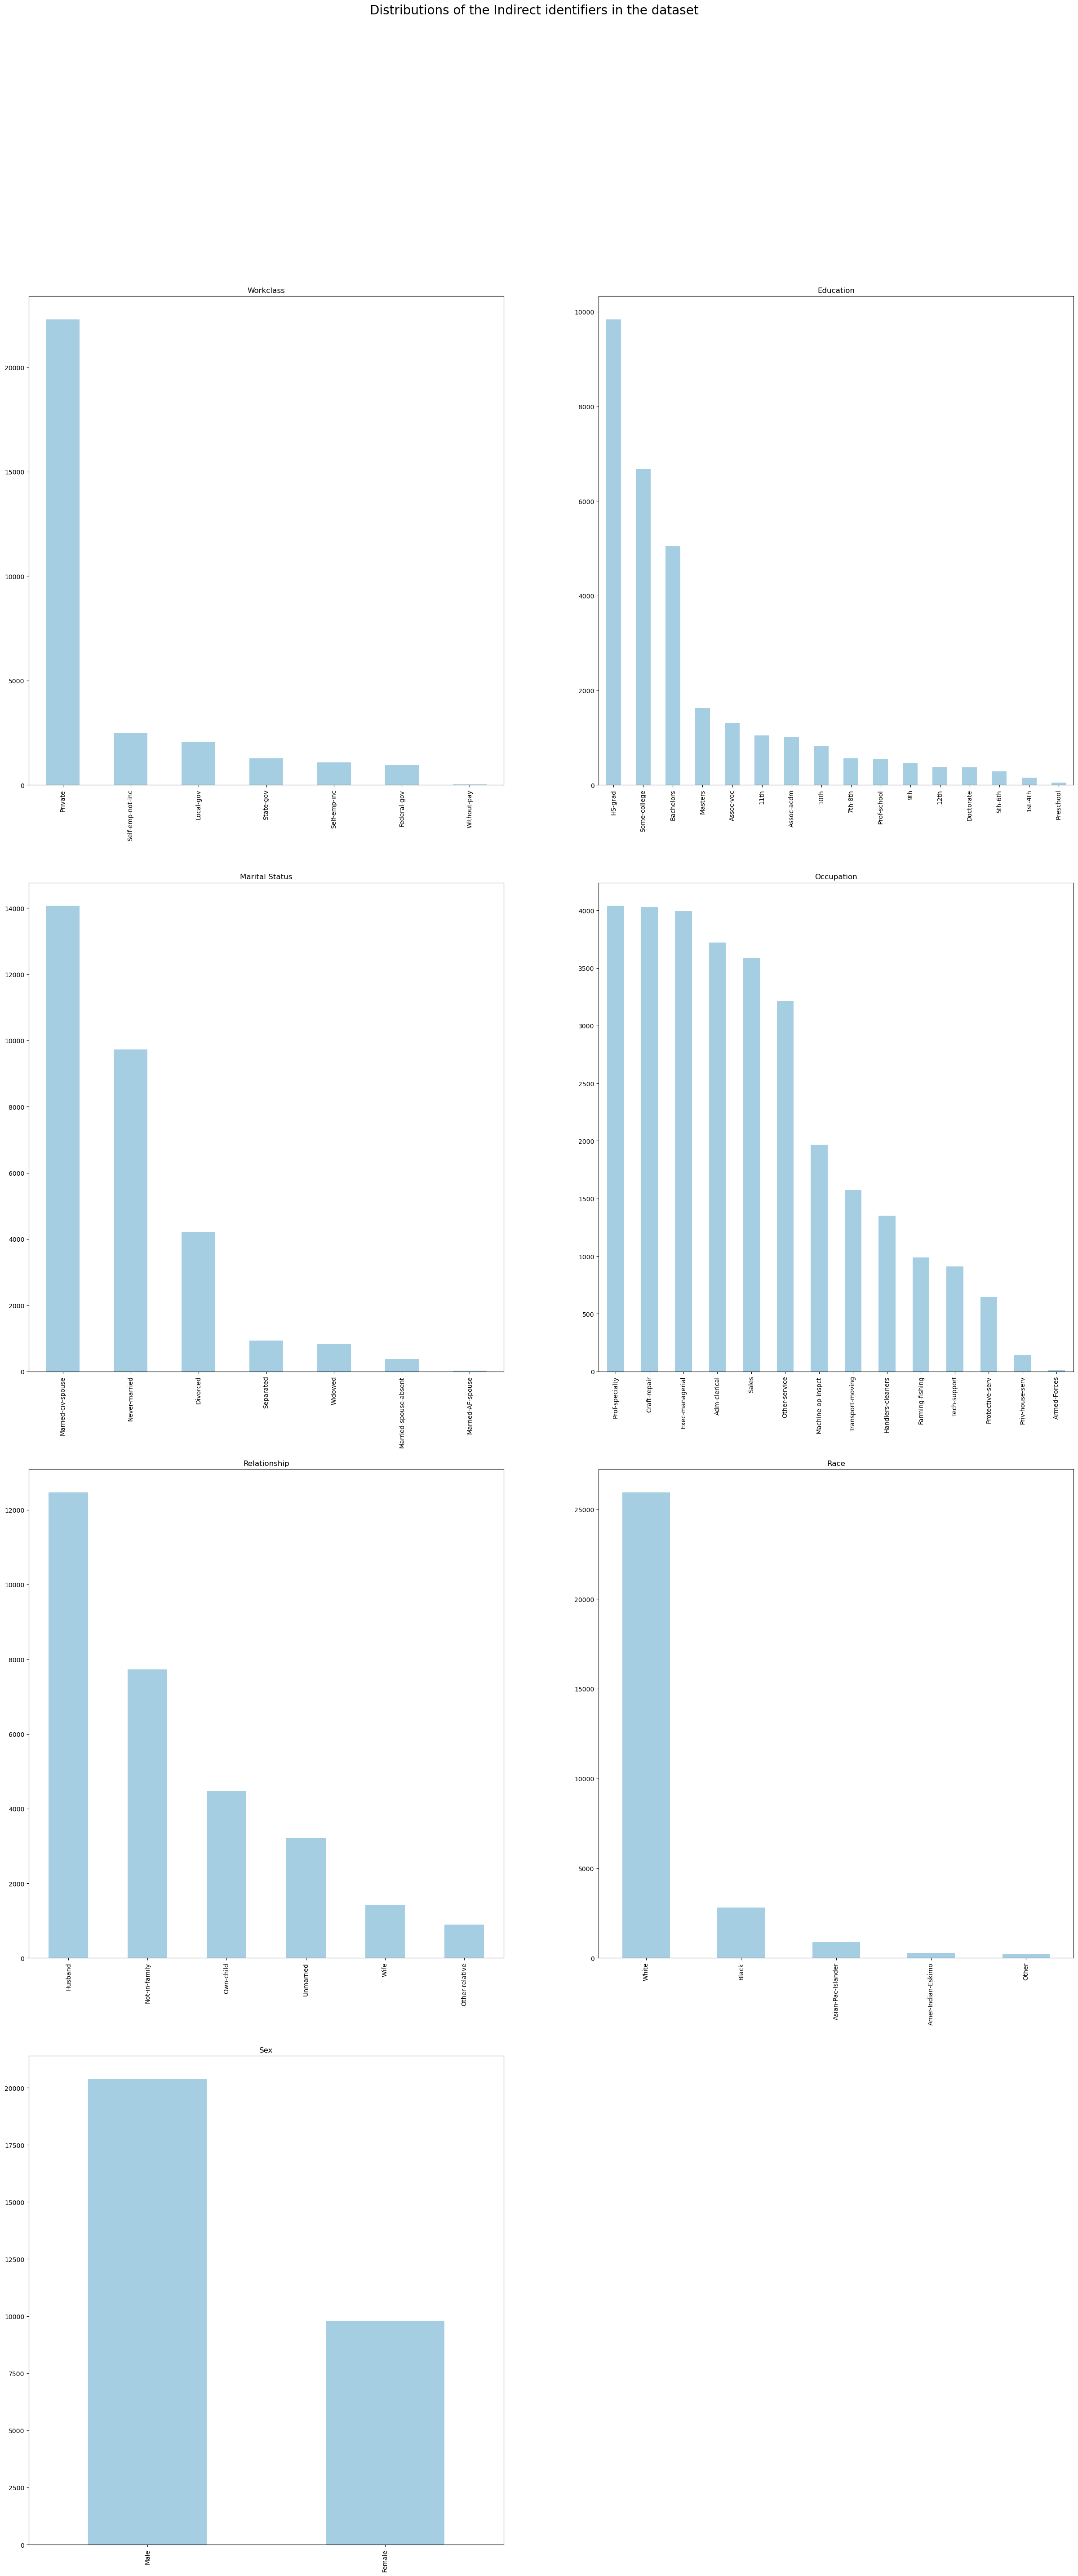

In [6]:
fig = plt.figure(figsize=(30, 65))
fig.suptitle("Distributions of the Indirect identifiers in the dataset", fontsize=20)
for i, column in enumerate(["Workclass", "Education", "Marital Status", "Occupation", "Relationship", "Race", "Sex"]):
    plt.subplot(4, 2, i+1)
    df[column].value_counts().plot(kind='bar', ax=plt.gca(), title=column, rot=90, colormap='Paired')

### 1.3 Adding Income to the dataset

1. Analyze the dataset and determine which columns are most likely to have an impact on income. Age, education level, work class, occupation, and hours per week are some common factors that can influence income.

2. Assign weights to these factors. For example, you could assign the following weights based on their perceived importance:

3. Normalize the values in each column to have a range of 0-1. 

4. Multiply the normalized values in each column by their respective weights.

5. Sum the weighted values for each row to obtain a composite score. This composite score will represent the synthetic income.

6. To create more realistic income values, you could multiply the composite score by a constant factor, such as the median income of the country or region.

7. Finally, add some random noise to the income values to create more variability and make the dataset more realistic. This can be achieved by adding or subtracting a small random percentage (e.g., +/- 5%) of the income value.

In [7]:
# Define the weights for each factor
df_temp = df.copy()
weights = {
    'Age': 0.2,
    'Education': 0.3, 
    'Workclass': 0.1,
    'Occupation': 0.2,
    'Hours per week': 0.1,
    'Sex':0.05,
    'Race':0.05,
}

# Normalize the numerical columns
for col in ['Age', 'Hours per week']:
    df_temp[col] = (df_temp[col] - df_temp[col].min()) / (df_temp[col].max() - df_temp[col].min())

# Convert categorical columns to numerical codes and normalize them
for col in ['Workclass', 'Education', 'Occupation', 'Sex', 'Race']:
    df_temp[col] = df_temp[col].astype('category').cat.codes
    df_temp[col] = (df_temp[col] - df_temp[col].min()) / (df_temp[col].max() - df_temp[col].min())

# Calculate the composite score
df_temp['composite_score'] = sum(df_temp[col] * weights[col] for col in weights)

# Multiply the composite score by a constant factor (e.g., median income)
median_income = 50000
df_temp['Income'] = df_temp['composite_score'] * median_income

# Add random noise to the income values
noise_factor = 0.05
df_temp['Income'] = df_temp['Income'] * (1 + noise_factor * (2 * np.random.rand(len(df)) - 1))

# Dataset with synthetic income column
# df_temp.to_csv("adult_with_synthetic_income.csv", index=False)
df_temp.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,...,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,composite_score,Income
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,0.301370,0.833333,77516,0.600000,13,Never-married,...,Not-in-family,1.0,1.0,2174,0,0.397959,United-States,<=50K,0.463403,22909.069277
1,Brandise Tripony,6/7/1988,150-19-2766,61523,0.452055,0.666667,83311,0.600000,13,Married-civ-spouse,...,Husband,1.0,1.0,0,0,0.122449,United-States,<=50K,0.495476,23664.901453
2,Brenn McNeely,8/6/1991,725-59-9860,95668,0.287671,0.333333,215646,0.733333,9,Divorced,...,Not-in-family,1.0,1.0,0,0,0.397959,United-States,<=50K,0.527587,25064.511659
3,Dorry Poter,4/6/2009,659-57-4974,25503,0.493151,0.333333,234721,0.066667,7,Married-civ-spouse,...,Husband,0.5,1.0,0,0,0.397959,United-States,<=50K,0.343682,18010.766783
4,Dick Honnan,9/16/1951,220-93-3811,75387,0.150685,0.333333,338409,0.600000,13,Married-civ-spouse,...,Wife,0.5,0.0,0,0,0.397959,Cuba,<=50K,0.446728,21730.334010


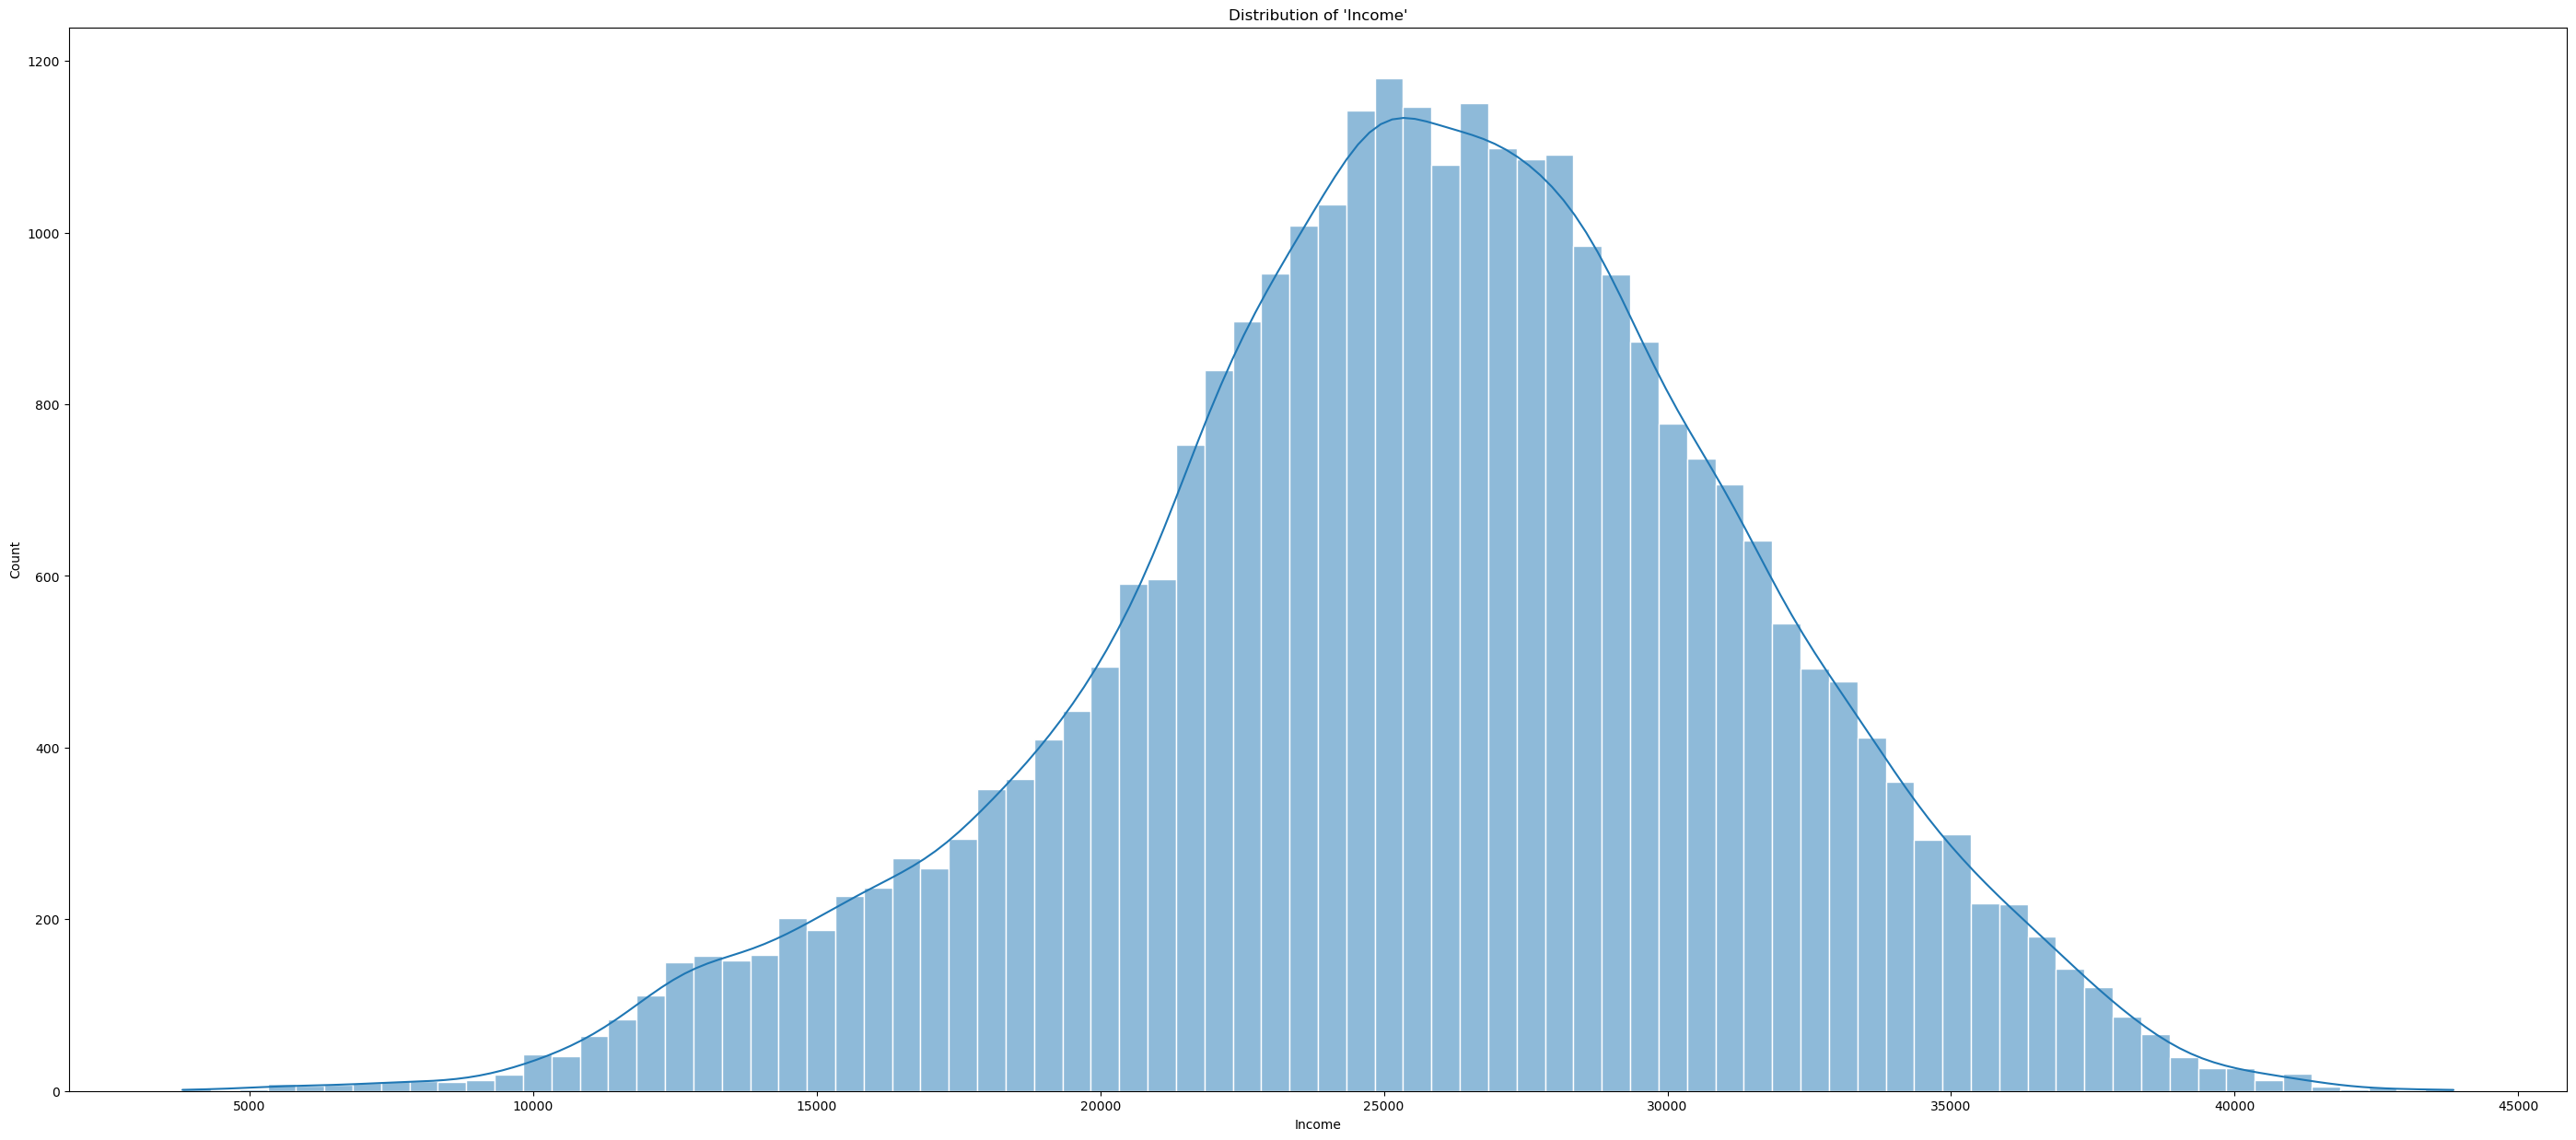

In [8]:
plt.figure(figsize=(35, 15))
plt.title("Distribution of 'Income'")
sns.set_style('darkgrid')
sns.histplot(data=df_temp, x="Income", bins=80, kde=True)
plt.show()

In [9]:
df = df.join(df_temp[["Income"]])
df

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Income
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,22909.069277
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,23664.901453
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,25064.511659
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,18010.766783
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,21730.334010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,Ardyce Golby,10/29/1961,212-61-8338,41328,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,24411.952253
32557,Jean O'Connor,6/28/1952,737-32-2919,94735,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,28791.380543
32558,Reuben Skrzynski,8/9/1966,314-48-0219,49628,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,22683.776108
32559,Caye Biddle,5/19/1978,647-75-3550,8213,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,18819.804648


## 2. Checking Utility & Privacy of differnetially privatized data

### 2.1 Variation in sample statistic after privatization (on numerical/semi-categorical data)

 Testing a range of values to see how the privacy budget affects the accuracy of the differentially private mean and standard deviation.

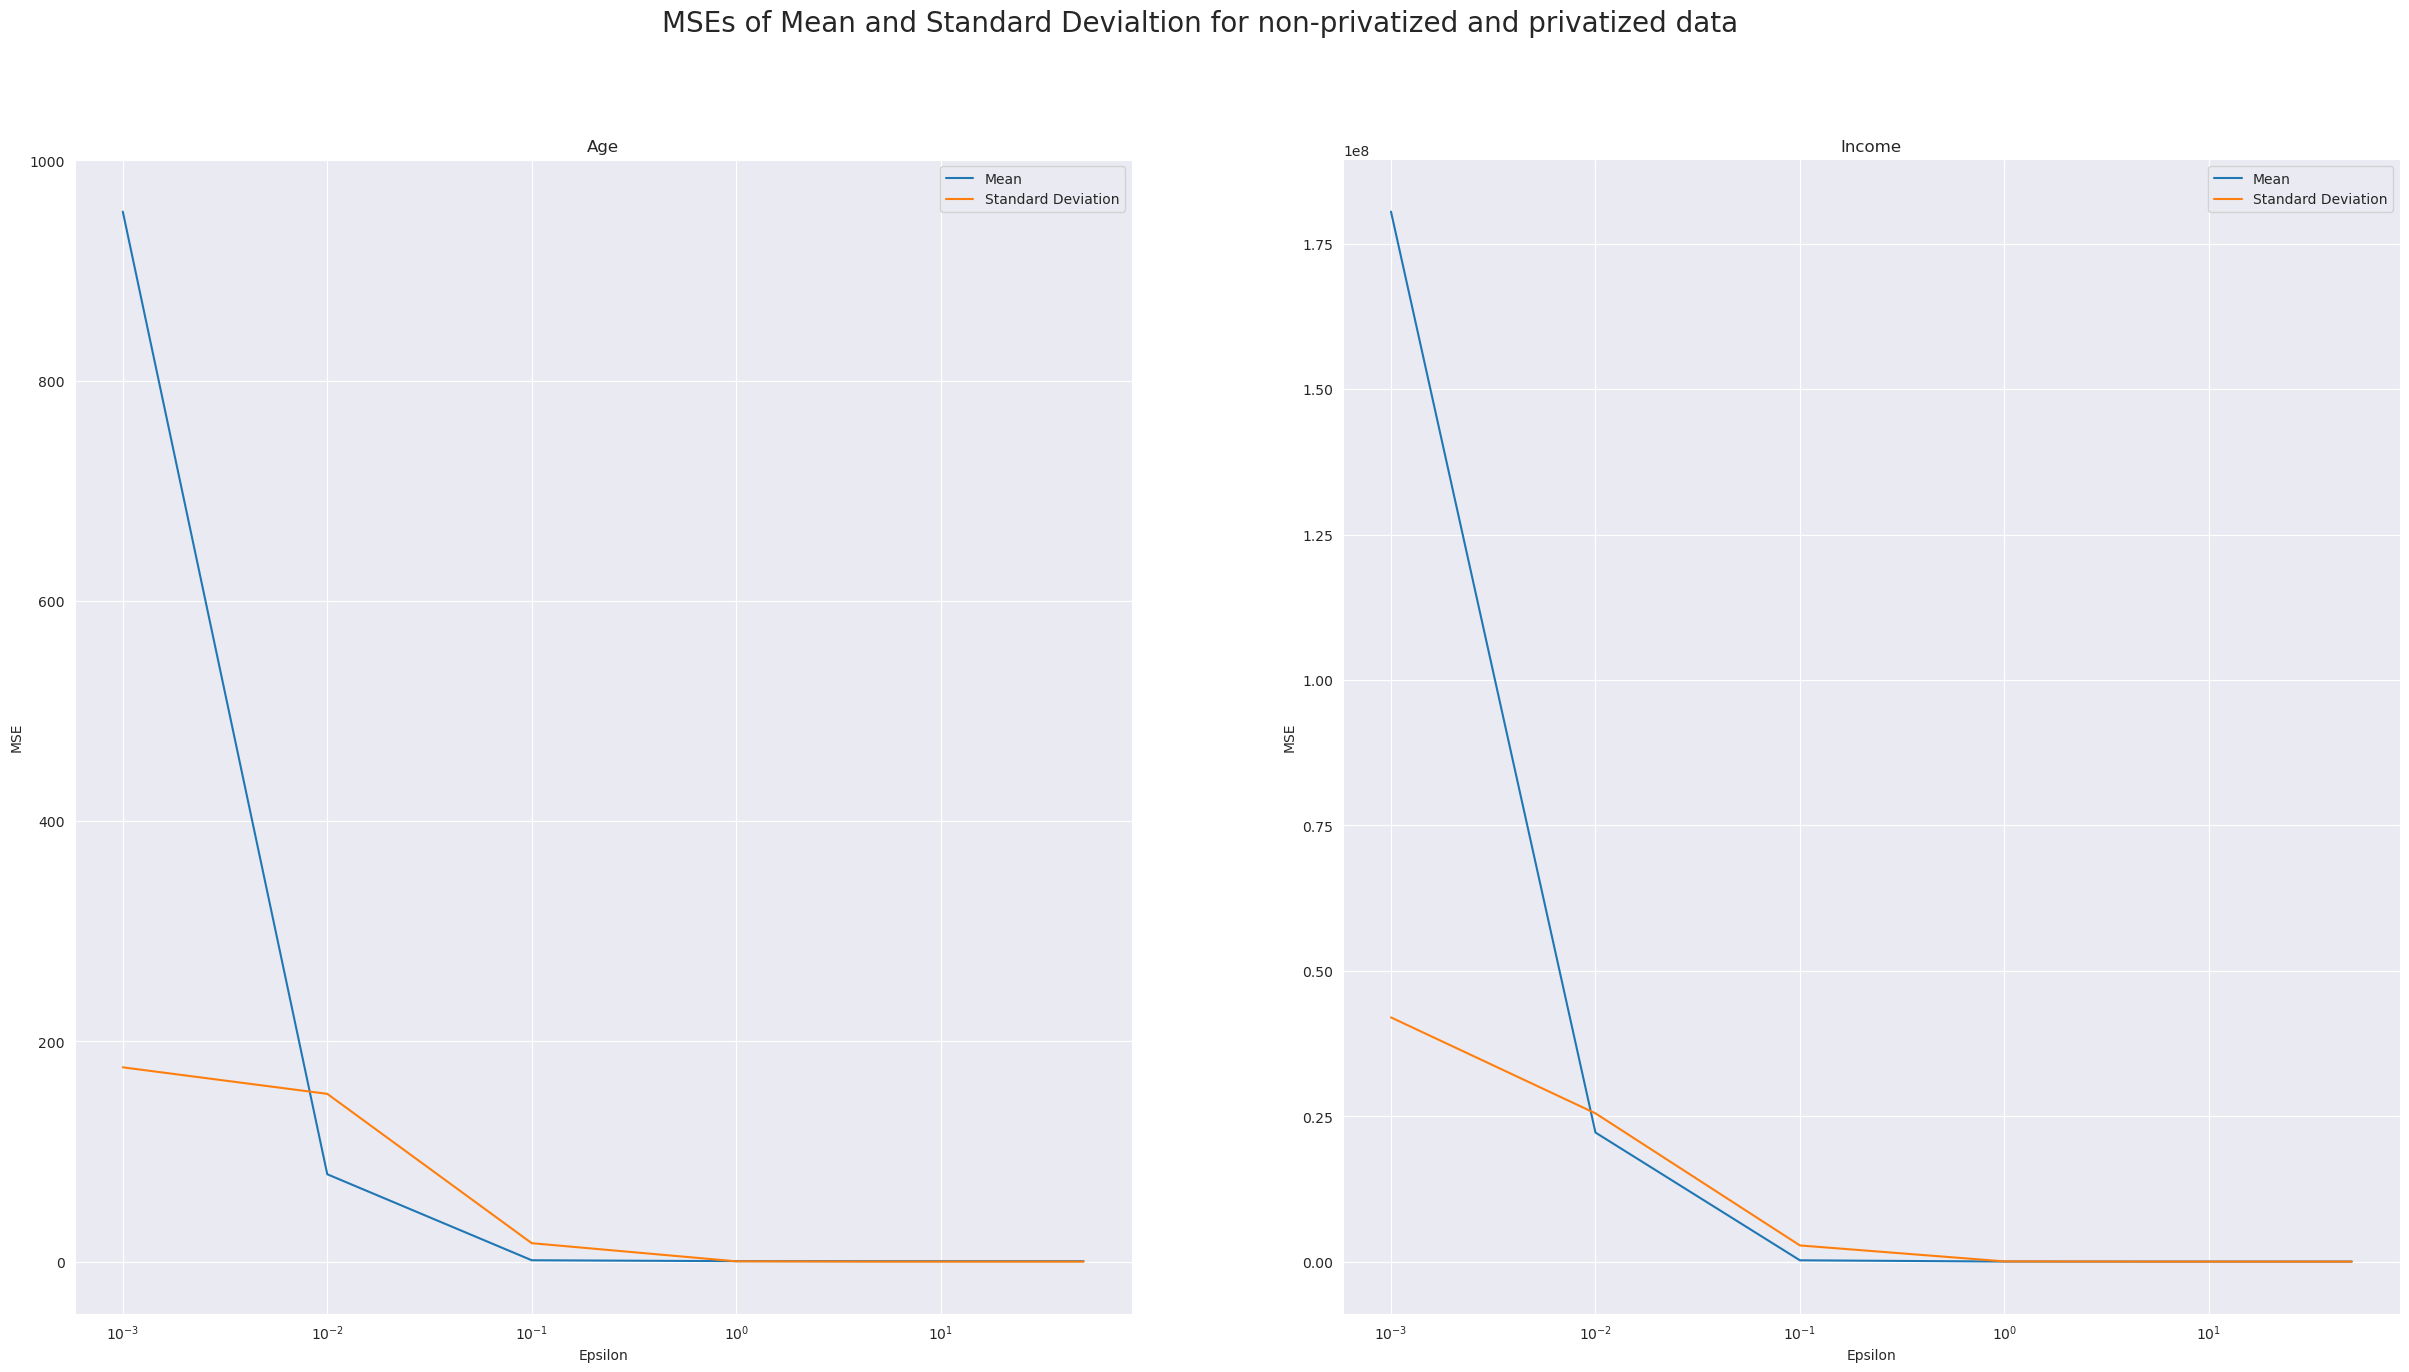

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30, 15))
fig.suptitle('MSEs of Mean and Standard Deviation for non-privatized and privatized data', fontsize=20)
axs_list = axs.flatten()
for index, column in enumerate(["Age", "Income"]):
    values = df[column].values
    
    # Split the dataset into original and release datasets using a random subsample
    subsample_size = 1000
    np.random.seed(123)
    idx = np.random.choice(len(values), size=subsample_size, replace=False)
    release_values = values[idx]
    original_values = np.delete(values, idx)
    
    # Compute the regular mean and standard deviation of the original dataset
    original_mean_values = np.mean(original_values)
    original_std_values = np.std(original_values)
    
    
    # Compute the differentially private mean and standard deviation using Diffprivlib
    epsilon_vals = [0.001, 0.01, 0.1, 1, 5, 10, 16, 20, 27, 38, 50]
    n_runs = 100
    mse_mean_values = []
    mse_std_values = []
    for epsilon in epsilon_vals:
        upper = max(values)
        dp_mean_values = []
        dp_std_values = []
        for i in range(n_runs):
            dp_mean_values.append(dp.mean(release_values, epsilon=epsilon))
            dp_std_values.append(dp.std(release_values, epsilon=epsilon))
        mse_mean = np.mean((dp_mean_values - original_mean_values) ** 2)
        mse_std = np.mean((dp_std_values - original_std_values) ** 2)
        
        mse_mean_values.append(mse_mean)
        mse_std_values.append(mse_std)
        
        
    ax = axs_list[index]
    ax.semilogx(epsilon_vals, mse_mean_values, label="Mean")
    ax.semilogx(epsilon_vals, mse_std_values, label="Standard Deviation")
    ax.set_title(column)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("MSE")
    ax.legend()
    
    
plt.show()

The graph above shows the difference between the actual mean/std of the dataset (i.e., the original value) and the differentially private mean/stf (i.e., the value after anonymization) for different epsilon values
* If ε is small: More privacy is preserved but data accuracy gets worse. 
* If ε is large: Privacy will be worse but data accuracy will be preserved. Note that ε goes from 0 to infinity.


### 2.2 Utility using Query Based DP

#### 2.2.1 Helper functions

In [11]:
def exponential(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]
    
    # Calculate the probability for each element, based on its score
    probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
    
    # Normalize the probabilties so they sum to 1
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)

    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

In [12]:
# We use this measure of utility assuming that the attacker is after the some information such as "How many people are married?"
def utility(data, privated_data):
    dist = abs(data.value_counts() - privated_data.value_counts())
    dist = dist.fillna(0)
    # return -np.sum([(a * a) for a in dist])
    return sum(dist)

In [13]:
# Score function
def score(data, option):
    return data.value_counts()[option]/1000

#### 2.2.2 Checking Utility across different columns


Calculating utilities for column Workclass
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Calculating utilities for column Education
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Calculating utilities for column Marital Status
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Calculating utilities for column Race
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50


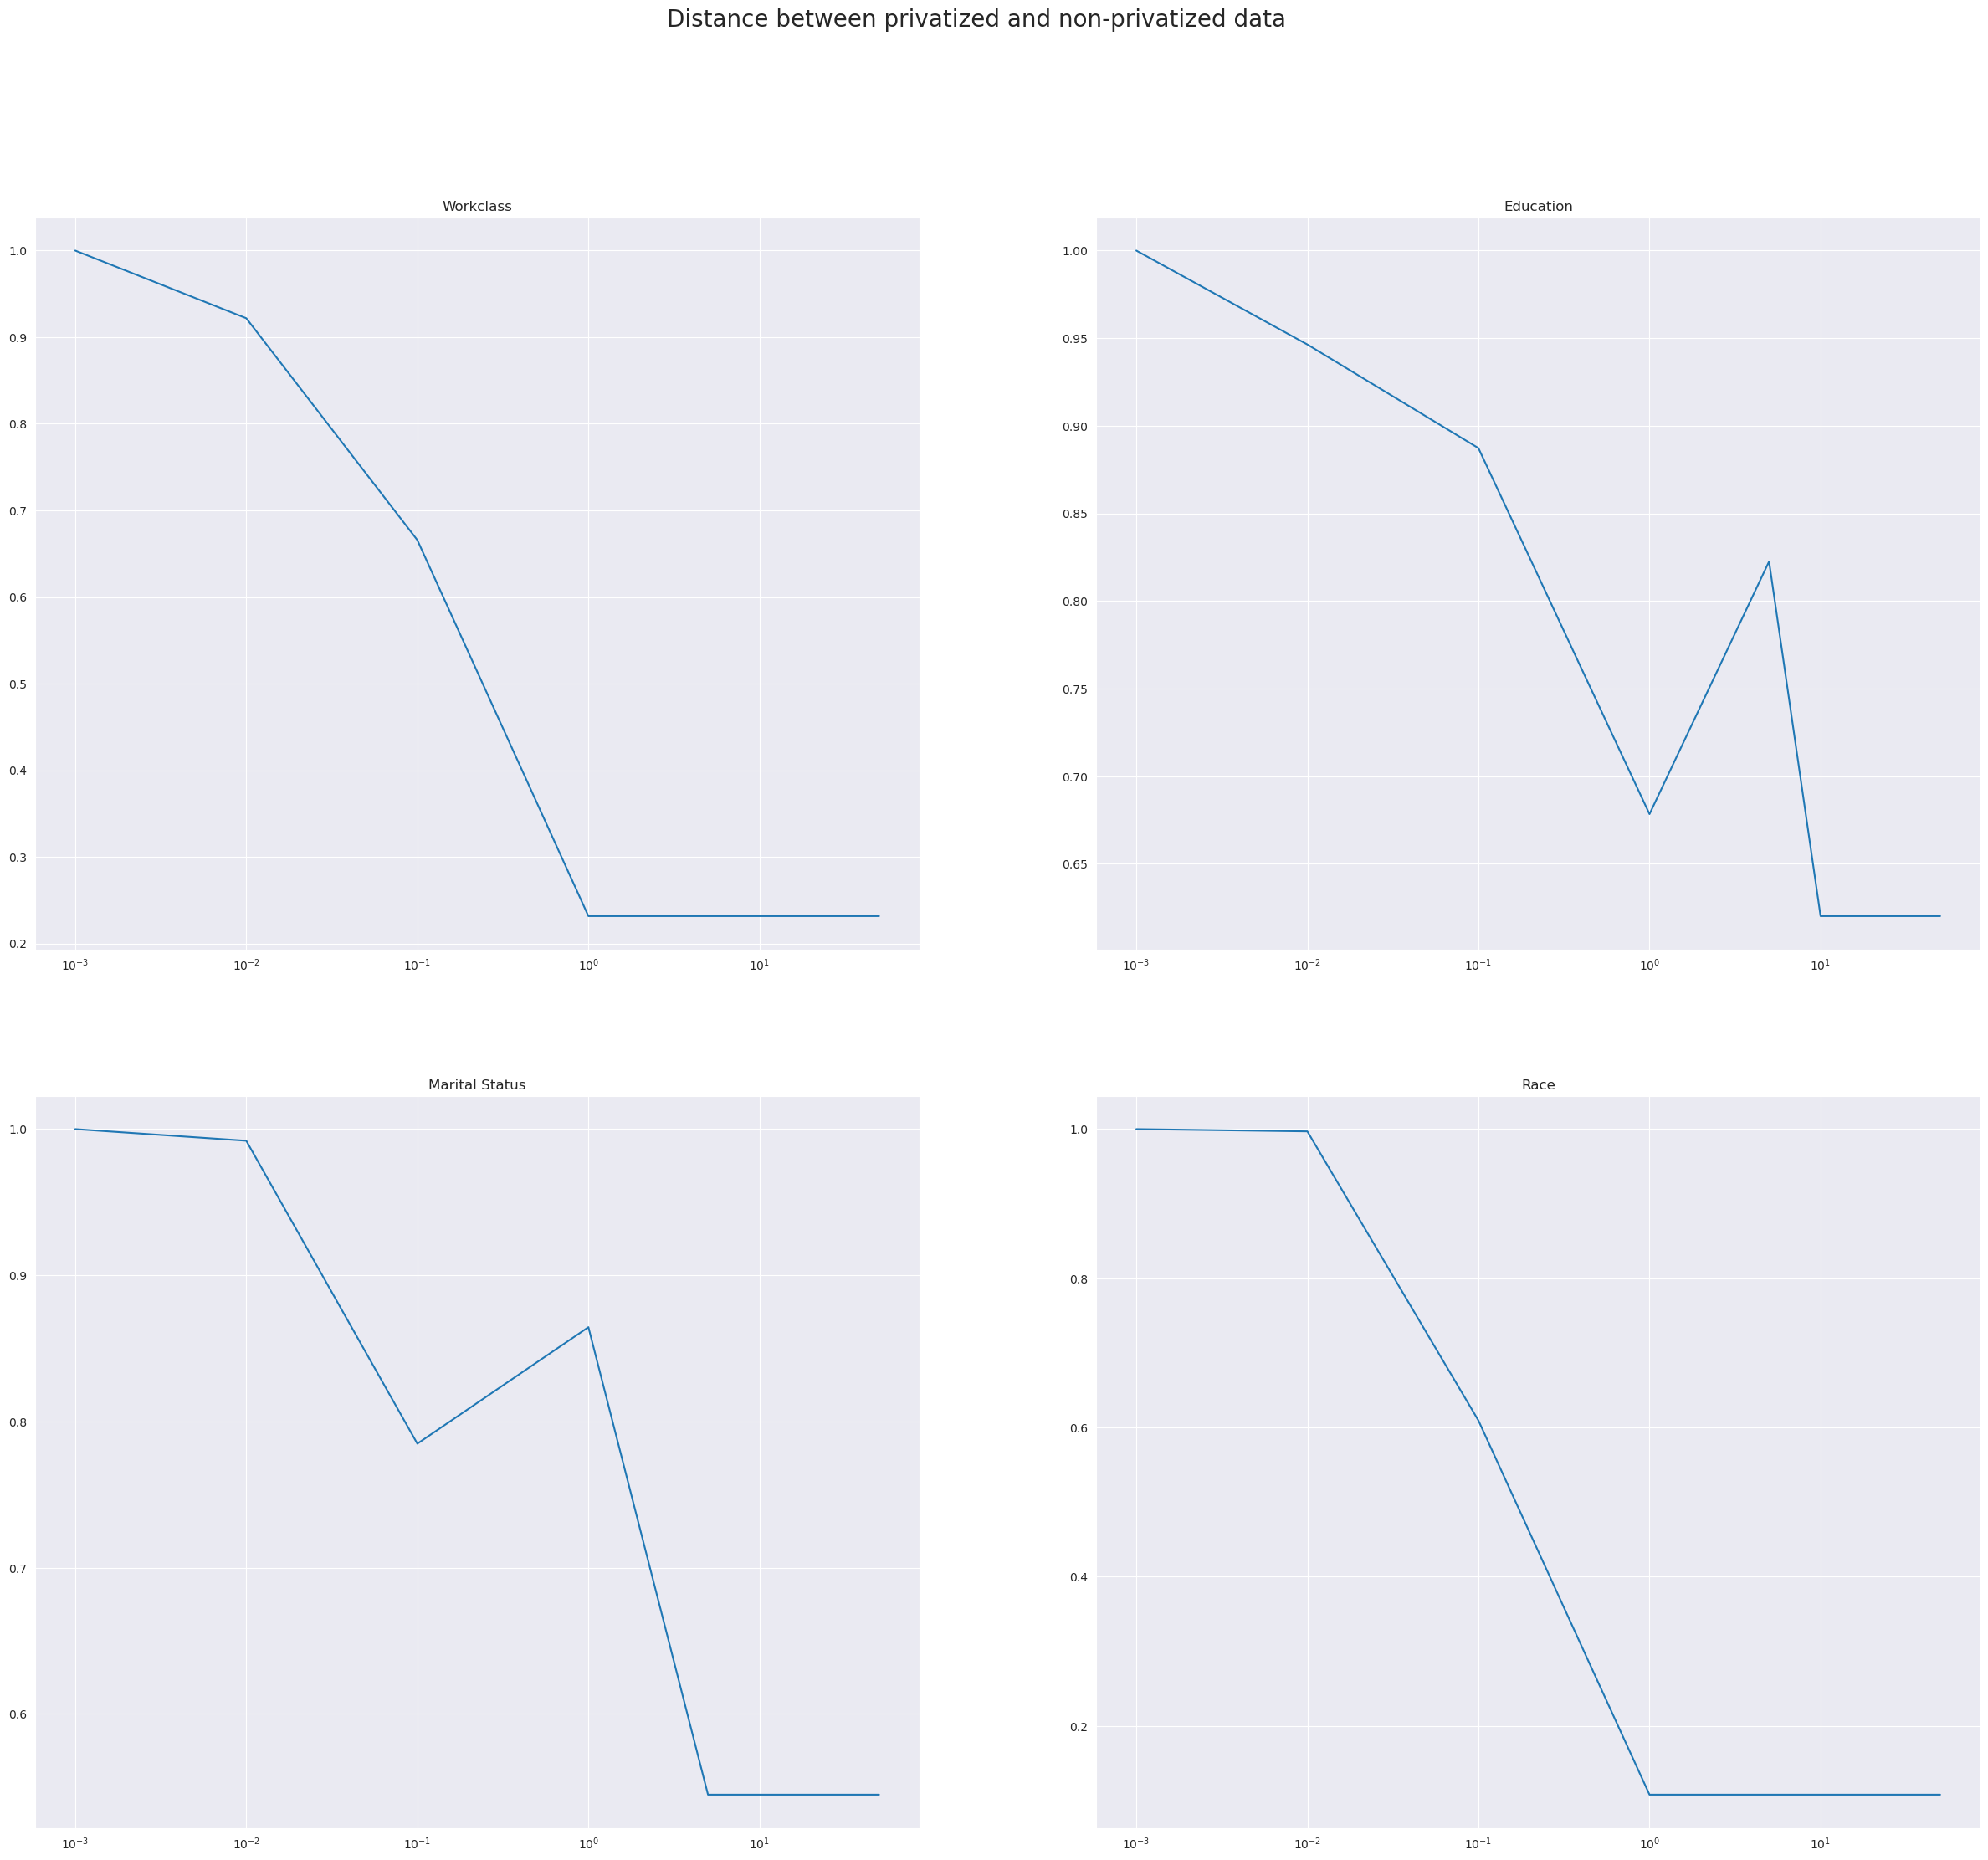

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30, 25))
fig.suptitle('Distance between privatized and non-privatized data', fontsize=20)
axs_list = axs.flatten()
for i, column in enumerate(["Workclass", "Education", "Marital Status", "Race"]):
    print("\nCalculating utilities for column {}".format(column))
    epsilons = [0.001, 0.01, 0.1, 1, 5, 10, 16, 20, 27, 38, 50]
    utilitys = []
    for epsilon in epsilons:
        r = [exponential(df[column], df[column].unique(), score, 1, epsilon) for i in range(1000)]
        u = utility(df[column].iloc[0:1000], pd.Series(r))
        print("For Epsilon " + str(epsilon))
        utilitys.append(u)
    
    norm = [float(i)/max(utilitys) for i in utilitys]
    plt.subplot(2, 2, i+1)
    plt.title(column)
    plt.semilogx(epsilons, norm)
    
for ax in axs.flat:
    ax.set(xlabel='Epsilons', ylabel='Distance between original and privatized data')
    ax.label_outer()
    
plt.show()

### 2.3 Epsilon in Machine Learning - How is Privacy affected?

From the below charts, as the value of epsilon increases, the accuracy of the differential privatized Logistic Regression model improves, approaching the level of accuracy obtained without differential privacy. This improvement in accuracy is indicative of better prediction of the target variable, which is typically a sensitive attribute. This is an indication of the potential risk to the privacy of individuals as better accuracy indicates lesser noise and hence lesser privacy meaning an attacker could predict the target variable given they have the rest of the information.


Column Sex is considered the target variable
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Column Race is considered the target variable
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Column Education is considered the target variable
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Column Marital Status is considered the target variable
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For Epsilon 5
For Epsilon 10
For Epsilon 16
For Epsilon 20
For Epsilon 27
For Epsilon 38
For Epsilon 50

Column Workclass is considered the target variable
For Epsilon 0.001
For Epsilon 0.01
For Epsilon 0.1
For Epsilon 1
For E

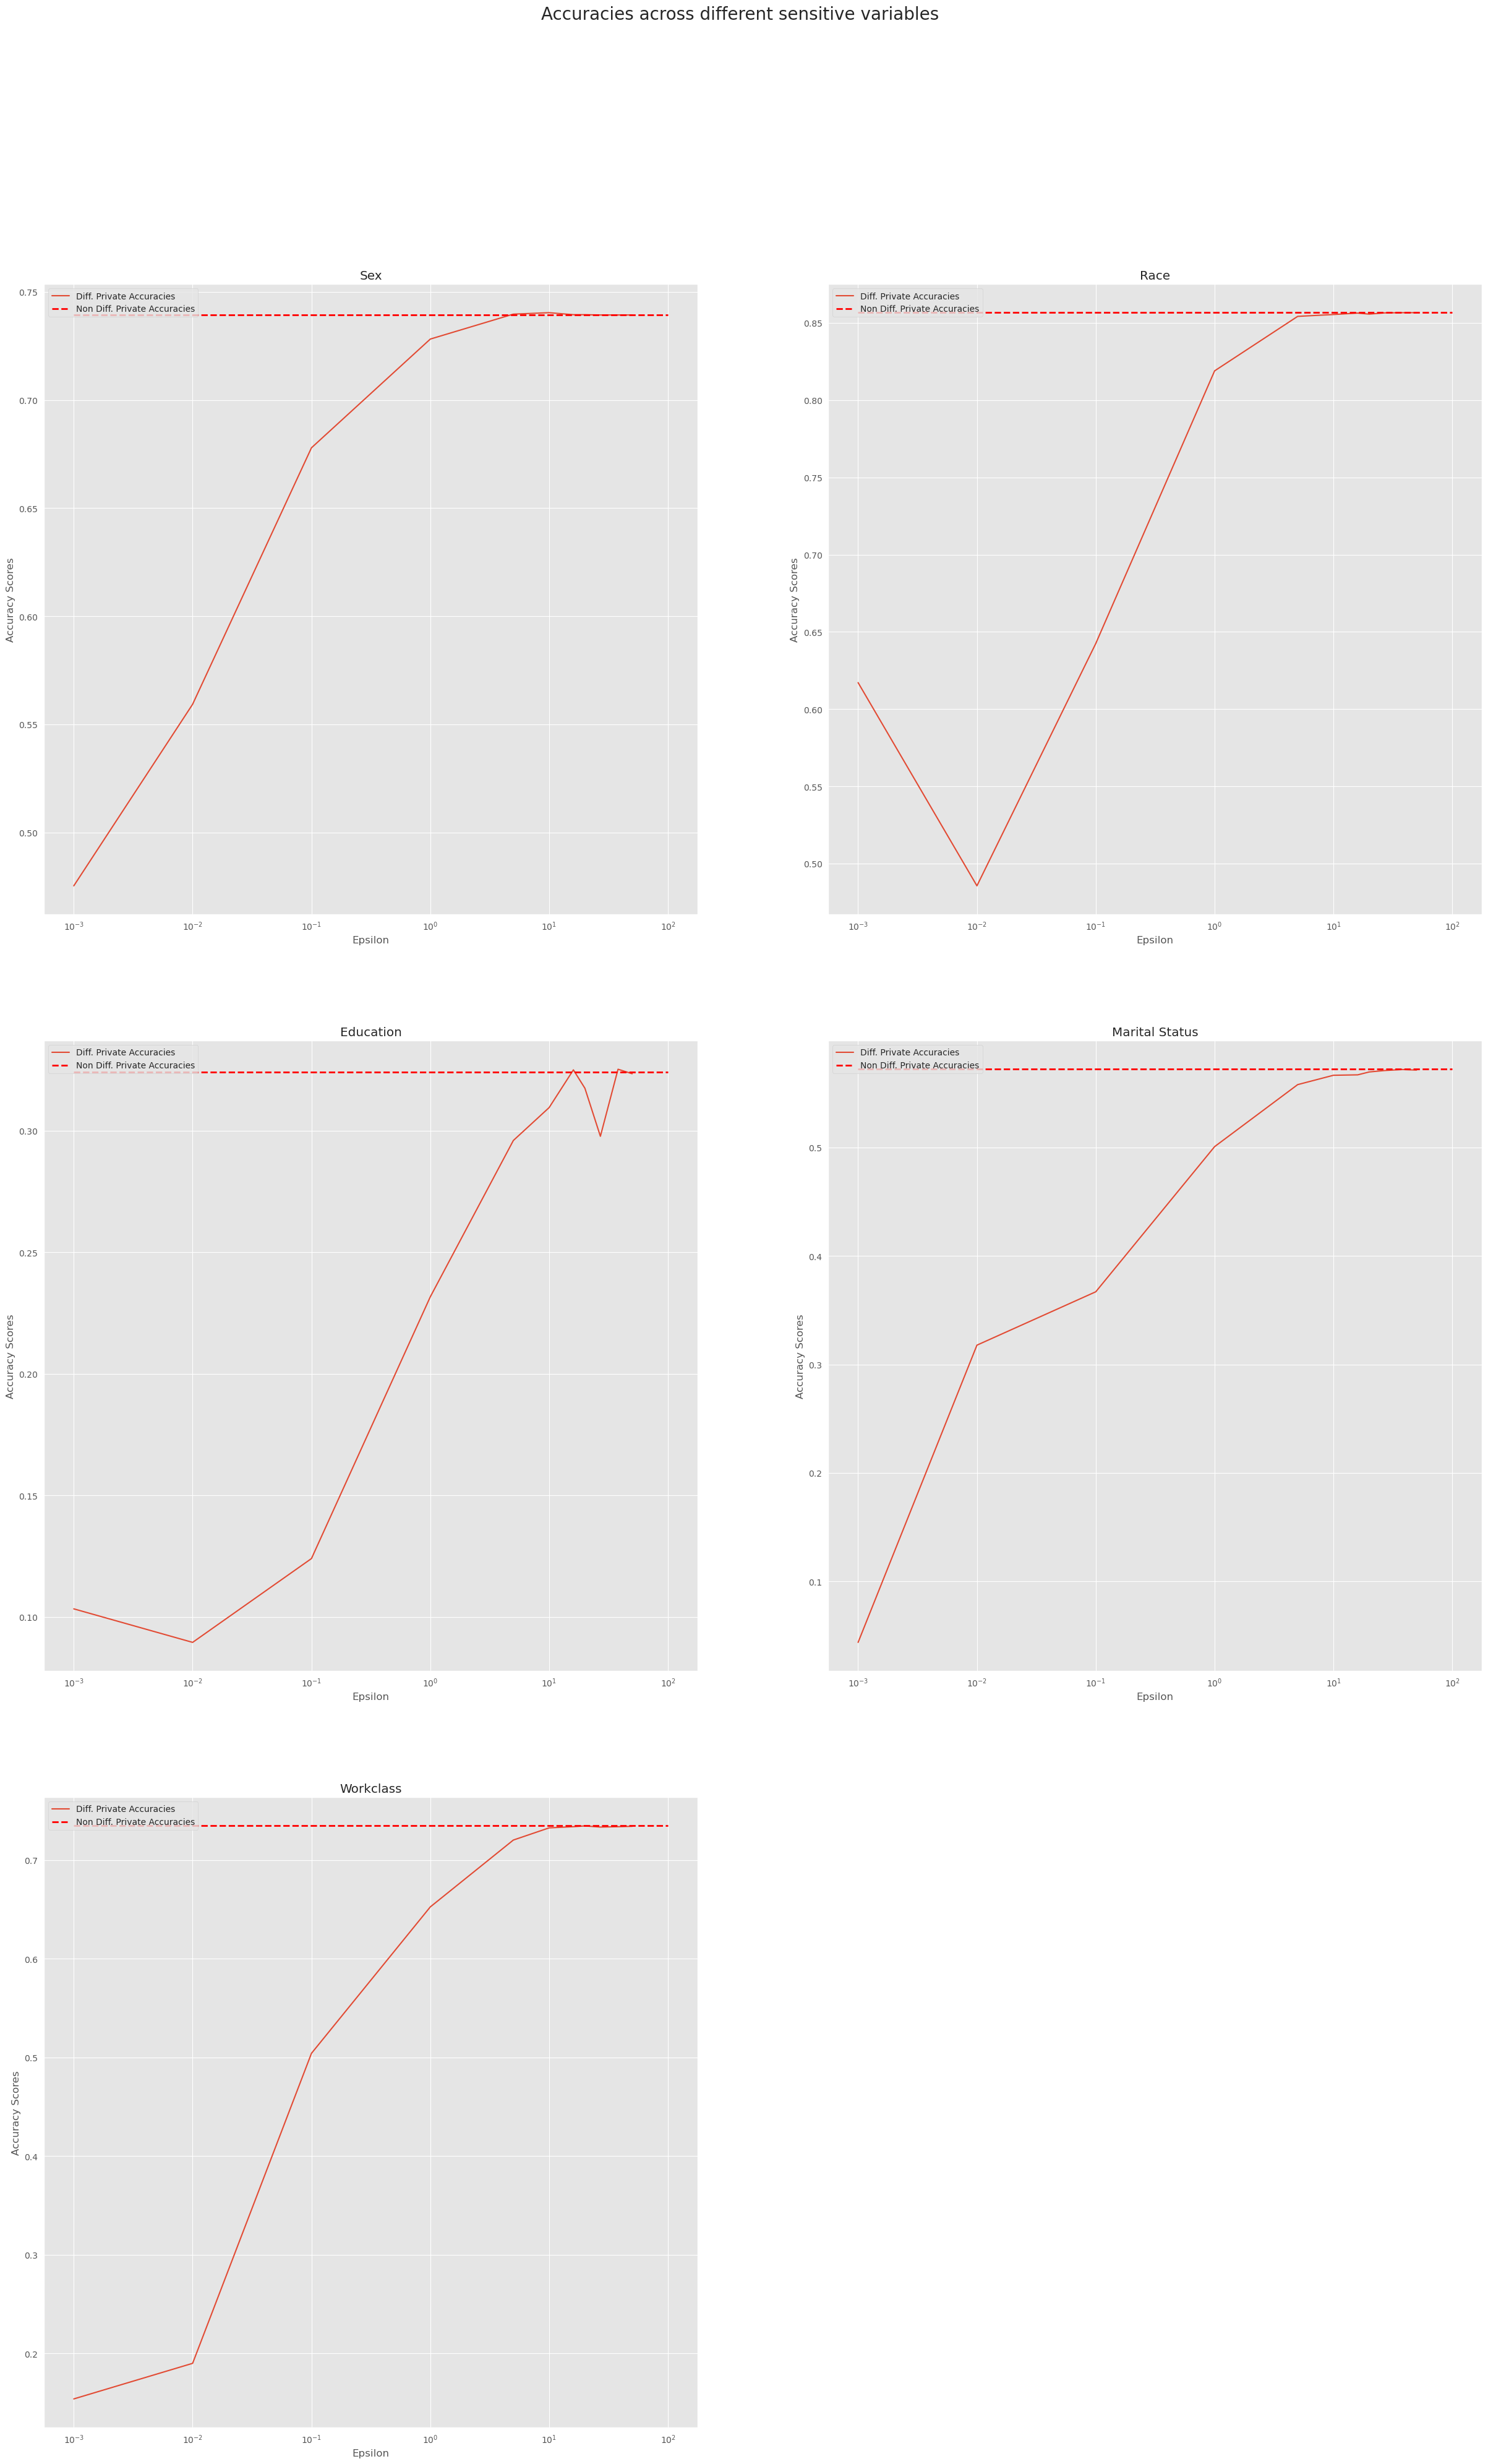

In [32]:
# Repeating the machine learning ptocess across 4 columns
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(30, 45))
fig.suptitle('Accuracies across different sensitive variables', fontsize=20)
axs_list = axs.flatten()
for i, column in enumerate(["Sex", "Race", "Education", "Marital Status", "Workclass"]):
    # Getting the data with the relevant columns
    print("\nColumn {} is considered the target variable".format(column))
    df_ml = df[["Sex", "Race", "Education", "Marital Status", "Workclass"]]
    columns = df_ml.columns.values.tolist()
    columns.remove(column)
    df_dummies = pd.get_dummies(df_ml, columns=columns)
    
    # Deciding the target and input variales; Here we assume the attacker knows all input and is trying to predict the target variable
    x_reg = df_dummies.copy()
    y_reg = x_reg.pop(column)
    
    
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x_reg, y_reg, random_state = 0)
    
    # Applying differentially privatized Logistic regression algorith with different values of Epsilon
    accuracy_scores = []
    epsilons = [0.001, 0.01, 0.1, 1, 5, 10, 16, 20, 27, 38, 50]
    for epsilon in epsilons:
        print("For Epsilon " + str(epsilon))
        lg_model = LogisticRegression(epsilon=epsilon, max_iter=500, random_state=42)
        lg_model.fit(X_train, y_train)
        predictions = lg_model.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, predictions))
        
    # Applying non-privatized Logistic Regression algorithm
    lg_model_2 = LR_skl(max_iter=500, random_state=42)
    lg_model_2.fit(X_train, y_train)
    predictions_2 = lg_model_2.predict(X_test)
    ac_Score = accuracy_score(y_test, predictions_2)
    
    ax = axs_list[i]
    ax.semilogx(epsilons, accuracy_scores, label='Diff. Private Accuracies')
    ax.hlines(y=ac_Score, xmin=0.001, xmax=100, linewidth=2, color='r', label='Non Diff. Private Accuracies', linestyle='--')
    ax.set_title(column)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Accuracy Scores")
    ax.legend()

axs_list[5].set_axis_off()    
plt.show()

## 3. Analysing the Risk in differentially privatized data

Since columns such as Sex, Race, Working class, Education and Marital status can disclose confidential information with respect to the individual's identity, these can be labeled as Quasi (Indirect) identifiers and hence can be considered as key variables in the data set.

### 3.1 Risk disclosure

Checking if the dataset satisfies k-anonymity with k=2 before the sensitive variables are differentially privatised.

In [16]:
df_anon = df.groupby(["Sex", "Race", "Education", "Marital Status", "Workclass"]).size().reset_index(name = "Frequency")
df_anon

,Sex,Race,Education,Marital Status,Workclass,Frequency
0,Female,Amer-Indian-Eskimo,10th,Divorced,Private,1
1,Female,Amer-Indian-Eskimo,10th,Married-civ-spouse,Federal-gov,1
2,Female,Amer-Indian-Eskimo,10th,Married-civ-spouse,Private,1
3,Female,Amer-Indian-Eskimo,10th,Married-spouse-absent,Self-emp-not-inc,1
4,Female,Amer-Indian-Eskimo,10th,Never-married,Private,1
...,...,...,...,...,...,...
1478,Male,White,Some-college,Separated,State-gov,7
1479,Male,White,Some-college,Widowed,Local-gov,1
1480,Male,White,Some-college,Widowed,Private,8
1481,Male,White,Some-college,Widowed,Self-emp-inc,4


In [17]:
df_anon["Key"] = df_anon[["Sex", "Race", "Education", "Marital Status", "Workclass"]].apply("-".join, axis=1)
df_anon.sort_values(by=['Frequency'])

,Sex,Race,Education,Marital Status,Workclass,Frequency,Key
0,Female,Amer-Indian-Eskimo,10th,Divorced,Private,1,Female-Amer-Indian-Eskimo-10th-Divorced-Private
747,Male,Amer-Indian-Eskimo,Bachelors,Never-married,Private,1,Male-Amer-Indian-Eskimo-Bachelors-Never-marrie...
748,Male,Amer-Indian-Eskimo,Bachelors,Never-married,Self-emp-not-inc,1,Male-Amer-Indian-Eskimo-Bachelors-Never-marrie...
749,Male,Amer-Indian-Eskimo,HS-grad,Divorced,Local-gov,1,Male-Amer-Indian-Eskimo-HS-grad-Divorced-Local...
761,Male,Amer-Indian-Eskimo,HS-grad,Never-married,State-gov,1,Male-Amer-Indian-Eskimo-HS-grad-Never-married-...
...,...,...,...,...,...,...,...
1470,Male,White,Some-college,Never-married,Private,905,Male-White-Some-college-Never-married-Private
1380,Male,White,HS-grad,Never-married,Private,1254,Male-White-HS-grad-Never-married-Private
1311,Male,White,Bachelors,Married-civ-spouse,Private,1407,Male-White-Bachelors-Married-civ-spouse-Private
1459,Male,White,Some-college,Married-civ-spouse,Private,1472,Male-White-Some-college-Married-civ-spouse-Pri...


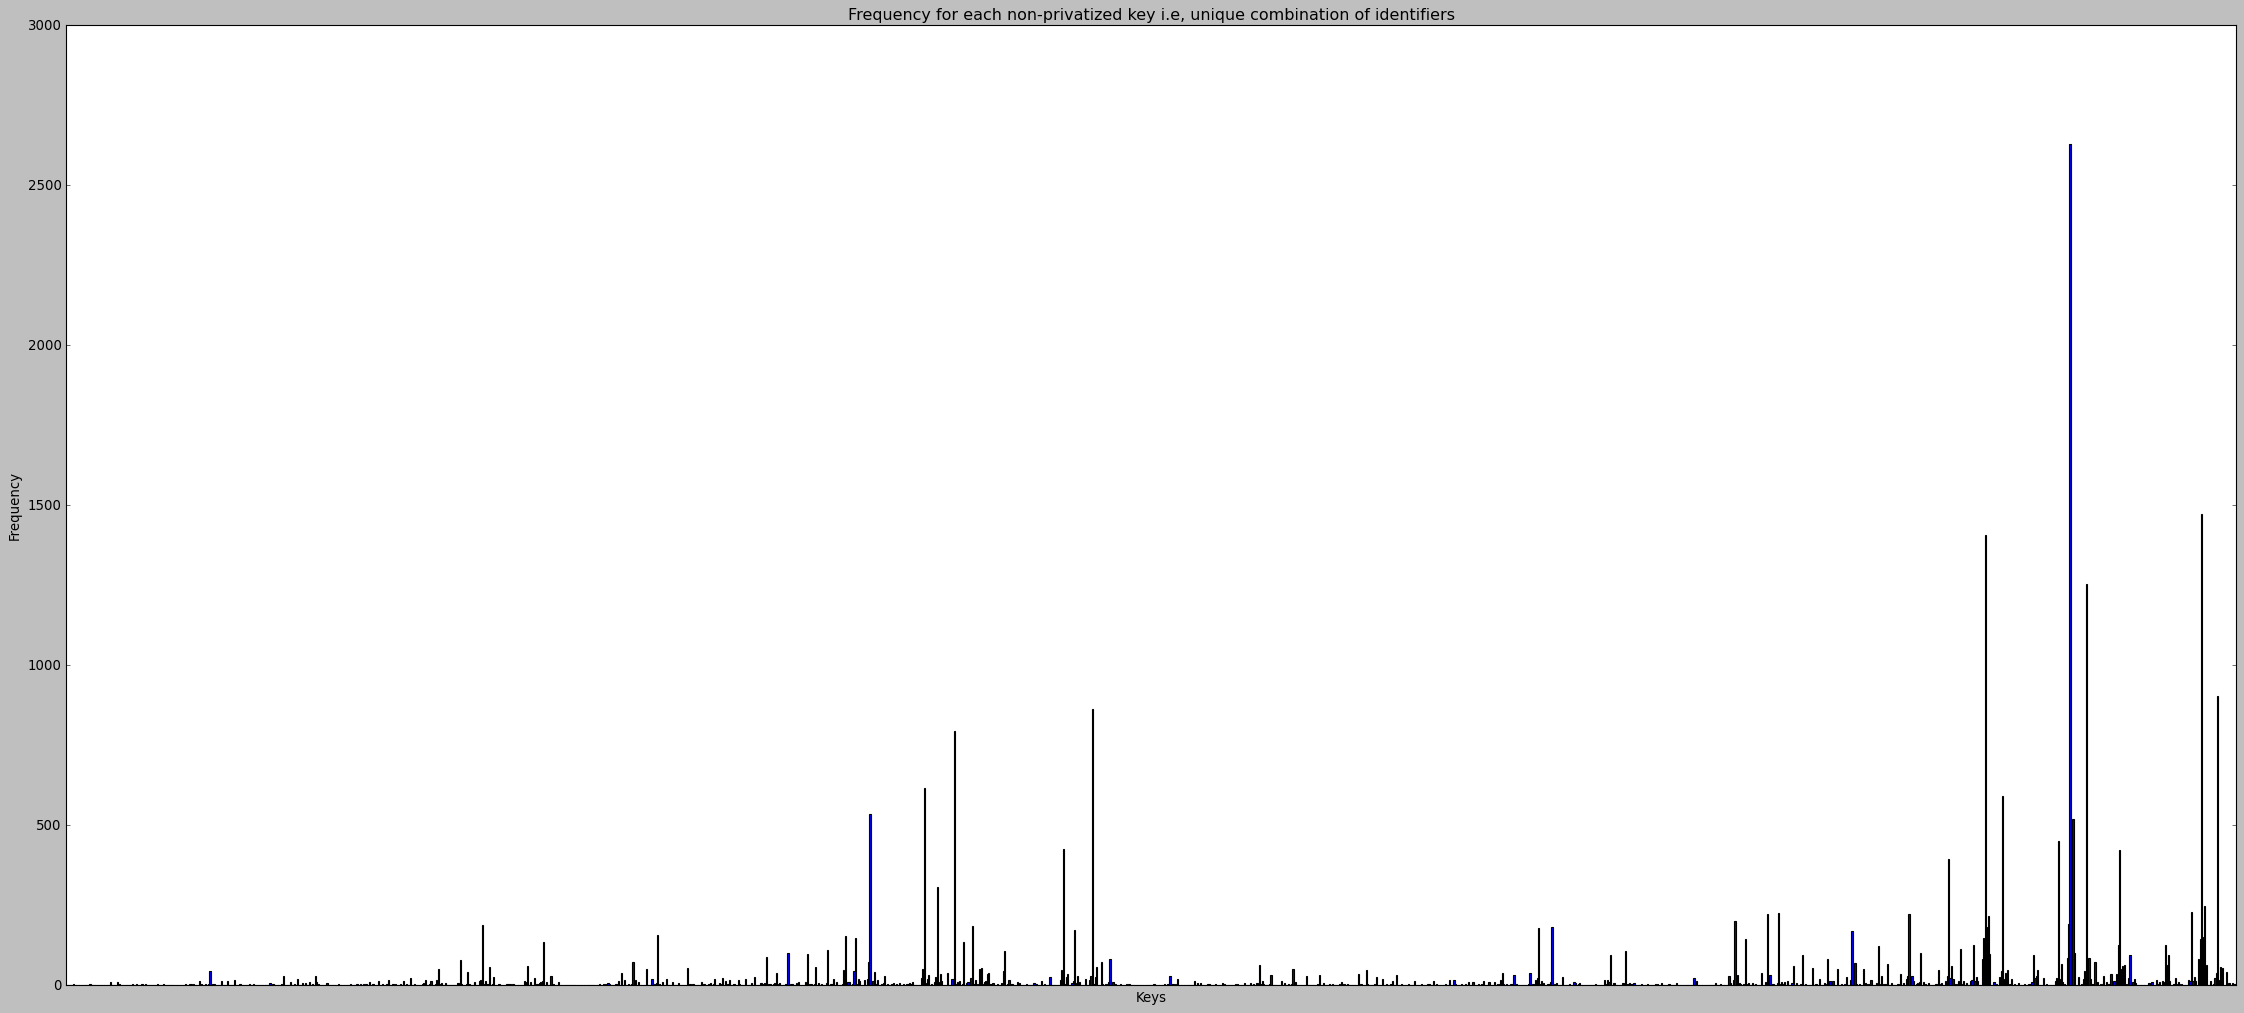

In [37]:
plt.style.use('classic')
plt.figure(figsize=(35, 15))
plt.bar(df_anon["Key"], df_anon["Frequency"])
plt.xlabel("Keys")
plt.ylabel("Frequency")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title("Frequency for each non-privatized key i.e, unique combination of identifiers")
plt.show()

Multiple combinations fail k-anonimity where k = 2 because these combinations have a frequency of one i.e., these are unique combinations, which can potentially reveal the identify of the individual involved

In [19]:
# Scoring function to calculate the score for each unique value in a column.
# Returns 1 if the value is equal to the original value, otherwise returns 0.
def scoring_function(value, original_value):
    return 1 if value == original_value else 0

# Exponential mechanism function that takes data, original_value, privacy parameter epsilon, and sensitivity.
# It calculates the scores for each value in the data using the scoring function, and then calculates the probabilities.
# Finally, it returns a treated value based on the probabilities.
def exponential_mechanism(data, original_value, epsilon, sensitivity):
    scores = np.array([scoring_function(value, original_value) for value in data])
    probabilities = np.exp(epsilon * scores / (2 * sensitivity))
    probabilities /= probabilities.sum()
    return np.random.choice(data, p=probabilities)

# Main function to generate treated data using the exponential mechanism.
# This function iterates through each column and row in the DataFrame,
# applies the exponential mechanism, and updates the treated_data DataFrame with the treated values.
def generate_treated_data(df, epsilon):
    treated_data = df.copy()
    df = df.reset_index(drop=True)  # Reset the index of the original DataFrame
    treated_data = treated_data.reset_index(drop=True)  # Reset the index of the treated DataFrame

    # Iterate through each column in the DataFrame
    for col in ["Sex", "Race", "Education", "Marital Status", "Workclass"]:
        unique_values = df[col].unique()  # Get unique values in the column
        sensitivity = len(unique_values) - 1  # Calculate the sensitivity for the column

        # Iterate through each row in the DataFrame
        for i in range(len(df)):
            original_value = df.at[i, col]  # Get the original value in the cell
            # Update the treated_data DataFrame with the treated value using the exponential mechanism
            treated_data.at[i, col] = exponential_mechanism(unique_values, original_value, epsilon, sensitivity)

    return treated_data

treated_data = generate_treated_data(df, 0.5)
print("Sample treated data with Epsilon 0.5\n")
print(treated_data.head())

Sample treated data with Epsilon 0.5

               Name        DOB          SSN    Zip  Age         Workclass  \
0  Karrie Trusslove   9/7/1967  732-14-6110  64152   39      Self-emp-inc   
1  Brandise Tripony   6/7/1988  150-19-2766  61523   50         State-gov   
2     Brenn McNeely   8/6/1991  725-59-9860  95668   38  Self-emp-not-inc   
3       Dorry Poter   4/6/2009  659-57-4974  25503   53      Self-emp-inc   
4       Dick Honnan  9/16/1951  220-93-3811  75387   28         Local-gov   

   fnlwgt     Education  Education-Num         Marital Status  \
0   77516          11th             13               Divorced   
1   83311    Assoc-acdm             13  Married-spouse-absent   
2  215646  Some-college              9     Married-civ-spouse   
3  234721  Some-college              7               Divorced   
4  338409          11th             13          Never-married   

          Occupation   Relationship                Race     Sex  Capital Gain  \
0       Adm-clerical  Not-i

In [ ]:
epsilons = [0.001, 0.01, 0.1, 1, 5, 10, 16, 20, 27, 38, 50]  # Set different privacy levels (epsilon values)
risk_metrics = []  # Initialize an empty list to store the risk metrics for each epsilon value

# Iterate through each epsilon value and calculate the corresponding risk metric
for epsilon in epsilons:
    # Generate the treated data using the exponential mechanism with the current epsilon value
    treated_data = generate_treated_data(df, epsilon)
    original_df = df.copy()
    
    # Calculate the risk ceiling (RC)
    categorical_columns = ["Sex", "Race", "Education", "Marital Status", "Workclass"]
    df['mean_matched_income'] = df.apply(
        lambda x: original_df.loc[
            (original_df[categorical_columns] == x[categorical_columns])
            .all(axis=1), 'Income']
        .mean(),axis=1)
    df['residuals_rc'] = abs(df['Income'] - df['mean_matched_income'])
    RC = df['residuals_rc'].mean()

    # Calculate the risk floor (RF)
    overall_mean_income = original_df['Income'].mean()
    df['residuals_rf'] = abs(df['Income'] - overall_mean_income)
    RF = df['residuals_rf'].mean()

    # Calculate the risk of the treated data (RT)
    treated_data['mean_matched_income'] = treated_data.apply(
        lambda x: original_df.loc[
            (original_df[categorical_columns] == x[categorical_columns])
            .all(axis=1), 'Income']
        .mean(),axis=1)
    treated_data['mean_matched_income'].fillna(overall_mean_income, inplace=True)
    treated_data['residuals_rt'] = abs(treated_data['Income'] - treated_data['mean_matched_income'])
    RT = treated_data['residuals_rt'].mean()

    # Calculate the risk metric (θ)
    theta = abs((RT - RF) / (RC - RF))

    # Append the risk metric to the list
    risk_metrics.append(theta)

# Plot the risk metrics as a function of the privacy level (epsilon value)
plt.plot(epsilons, risk_metrics)
plt.xlabel('Privacy level (epsilon)')
plt.ylabel('Risk metric (theta)')
plt.title('Risk metric vs. Privacy level')
plt.show()